ประกาศตัวแปร

In [1]:
import os
os.path.abspath("../..")

'/home/jovyan/ChestXray-14'

In [2]:
ROOT_PATH = os.path.abspath("../..")
CONFUSION_METRICS_PATH = f"{ROOT_PATH}/results/confusion"
CONFUSION_METRICS_PATH

'/home/jovyan/ChestXray-14/results/confusion'

เลือกโมเดลที่ต้องการ

In [3]:
fold_num = 5
model_name = f"EfficientNetB0_None_fold_{fold_num}"

อ่านจากไฟล์ประวัติ Threshold เทียบกับ Confusion metrics ของแต่ละโมเดล

In [4]:
import sys
sys.path.append(ROOT_PATH)

In [5]:
import numpy as np
import pandas as pd
from modules.dataset import LABELS

2023-04-11 10:27:52.603702: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


ROOT_PATH: /home/jovyan/ChestXray-14


In [6]:
def preprocessing_data(x):
    if "e+" in x:
        values = eval(x.replace(" ", ", "))
        return np.array(values)
    else:
        values = eval(x.replace("\n", "").replace(". ", ".,"))
        return np.array(values)

In [7]:
df = pd.read_csv(f"{CONFUSION_METRICS_PATH}/{model_name}.csv")
thresholds = df["thresholds"].values
TP = df["TP"].apply(preprocessing_data).values
TN = df["TN"].apply(preprocessing_data).values
FP = df["FP"].apply(preprocessing_data).values
FN = df["FN"].apply(preprocessing_data).values

แสดงผล

In [8]:
f1_thresholds_dict = dict()
for i_thresh, (tps, tns, fps, fns) in enumerate(zip(TP, TN, FP, FN)):
    for label, tp, tn, fp, fn in zip(LABELS, tps, tns, fps, fns):
        f1_score = 2*tp / (2*tp + fp + fn)
        try: 
            f1_thresholds_dict[label].append((thresholds[i_thresh], f1_score))
        except:
            f1_thresholds_dict[label] = [(thresholds[i_thresh], f1_score)]

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [10]:
def plot_compare(dictionary, name, x_label, y_label):
    plt.figure(figsize=(20,12))
    best_multiple_f1_list = []
    for i, (label, value) in enumerate(dictionary.items()):
        x, y = zip(*value)
        plt.plot(x, y, marker='.', label=label)
        
        y = np.array(y)
        best = y.argmax()
        sns.scatterplot(x=[x[best]], y=[y[best]], marker="X", s=300)
        
        best_multiple_f1_list.append(x[y.argmax()])

    plt.title(name)
    plt.legend()
    plt.xlabel(x_label, fontweight='bold')
    plt.ylabel(y_label, fontweight='bold')
    plt.ylim(-0.05, 1.05)
    plt.xlim(-0.05, 1.05)
    plt.show()
    return best_multiple_f1_list

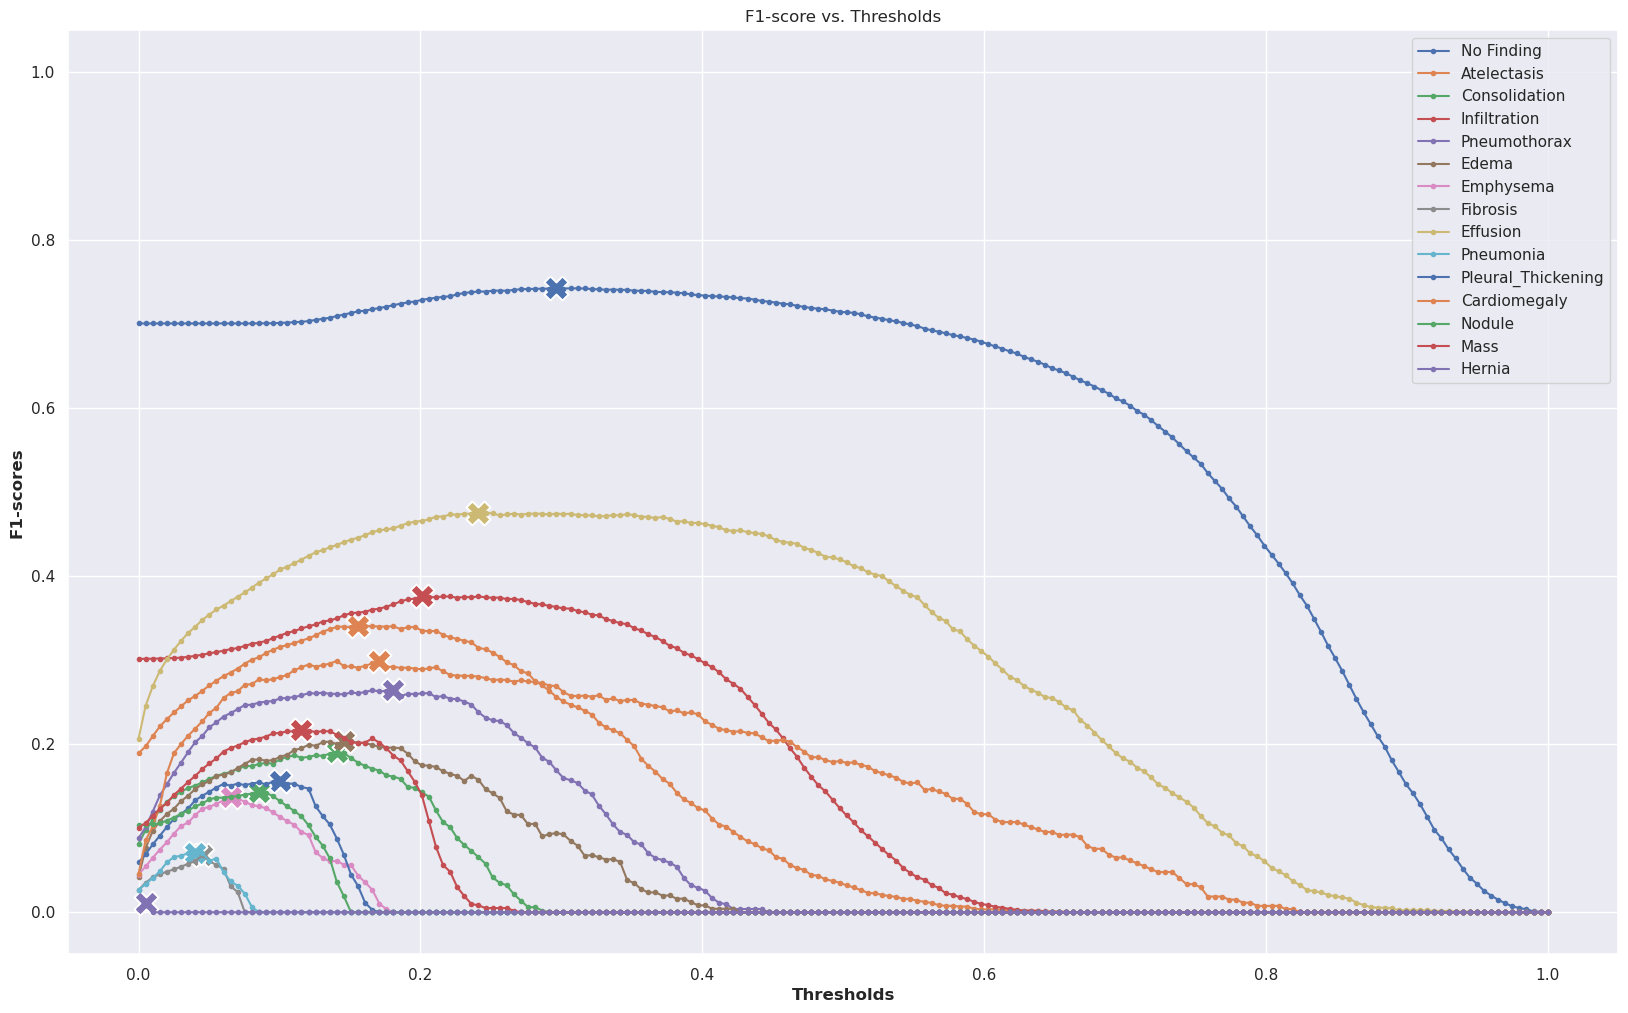

In [11]:
best_multiple_threshold = plot_compare(f1_thresholds_dict, name="F1-score vs. Thresholds", x_label='Thresholds', y_label='F1-scores')

In [12]:
best_multiple_threshold

[0.2964824120603015,
 0.1557788944723618,
 0.1407035175879397,
 0.2010050251256281,
 0.1809045226130653,
 0.1457286432160804,
 0.0653266331658291,
 0.0452261306532663,
 0.2412060301507537,
 0.0402010050251256,
 0.100502512562814,
 0.1708542713567839,
 0.0854271356783919,
 0.1155778894472361,
 0.0050251256281407]

ลองทำนายด้วยค่า Multiple threshold

In [13]:
def get_y_true(data):
    y_true=[]
    for X,y in data:
        for label in y:
            y_true.append(label)
    y_true = tf.Variable(y_true)
    return y_true

In [14]:
import tensorflow as tf
from modules.dataset import Dataset

In [15]:
dataset = Dataset()

# Dataset
train_dataset, test_dataset = dataset.get_kfold(fold_num, sample=False)

# Get y_true
y_true = get_y_true(test_dataset)

model_name = f"EfficientNetB0_None_fold_{fold_num}"

# Modeling
model = tf.keras.models.load_model(f"{ROOT_PATH}/results/models/{model_name}.h5")

2023-04-11 10:27:56.319236: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-11 10:27:57.140431: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8011 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 2g.10gb, pci bus id: 0000:b1:00.0, compute capability: 8.0


In [16]:
y_preds = model.predict(test_dataset)

2023-04-11 10:28:16.659560: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-04-11 10:28:17.593656: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-11 10:28:17.595124: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-11 10:28:17.595221: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-04-11 10:28:17.596522: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-11 10:28:17.596672: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


      7/Unknown - 5s 27ms/step

2023-04-11 10:28:18.907781: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1402/1402 [==============================] - 46s 29ms/step


In [17]:
y_preds

array([[3.63650411e-01, 5.44106700e-02, 7.77205601e-02, ...,
        4.85339276e-02, 2.56337952e-02, 1.26770892e-05],
       [5.50203502e-01, 2.17681453e-01, 3.98438275e-02, ...,
        4.18366082e-02, 3.44419852e-02, 5.48544573e-04],
       [2.17559800e-01, 2.92692214e-01, 1.80428863e-01, ...,
        5.10841124e-02, 7.90062249e-02, 1.14588719e-03],
       ...,
       [6.09347224e-01, 2.36975737e-02, 1.30008822e-02, ...,
        9.52602103e-02, 6.27335161e-02, 1.48538779e-03],
       [5.16610861e-01, 1.21293165e-01, 8.49977806e-02, ...,
        2.41315830e-02, 2.10375432e-02, 2.29526431e-05],
       [7.59687781e-01, 2.50630919e-02, 4.40667244e-03, ...,
        8.10561031e-02, 3.41762975e-02, 1.57950376e-03]], dtype=float32)

In [18]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [19]:
best_multiple_threshold

[0.2964824120603015,
 0.1557788944723618,
 0.1407035175879397,
 0.2010050251256281,
 0.1809045226130653,
 0.1457286432160804,
 0.0653266331658291,
 0.0452261306532663,
 0.2412060301507537,
 0.0402010050251256,
 0.100502512562814,
 0.1708542713567839,
 0.0854271356783919,
 0.1155778894472361,
 0.0050251256281407]

In [20]:
import seaborn as sns
from modules.dataset import LABELS
import matplotlib.pyplot as plt

sns.set(font_scale=1.5)

def plot_confusion_metics(confusion_metrics, threshold):
    fig = plt.figure(figsize=(20,30))
    fig.suptitle(f"Condusion Metrics for Threshold: {threshold[:5]}\n{threshold[5:10]}\n{threshold[10:]}", fontsize=30)
    
    for i, confusion_metrix in enumerate(confusion_metrics.numpy().astype('int64')):
        plt.subplot(5, 3, i+1)
        plt.subplots_adjust(left=0.1,
                            bottom=0.1,
                            right=0.9,
                            top=0.9,
                            wspace=0.4,
                            hspace=0.4)
        plt.title(LABELS[i], fontweight='bold', fontsize=16)
        sns.heatmap(confusion_metrix, cbar=False, annot=True, fmt="d", cmap="Greens", linewidths=.5, annot_kws={"fontsize":24})
        plt.xlabel('predicted label', fontweight='bold', fontsize=15)
        plt.ylabel('actual label', fontweight='bold', fontsize=15)
    

In [21]:
import numpy as np
import tensorflow_addons as tfa

def run_confusion_metrics():
    fig = plt.figure(figsize=(35,20))
    thresh_value = best_multiple_threshold
    metric = tfa.metrics.MultiLabelConfusionMatrix(num_classes=15)
    metric.update_state(y_true,
                        np.greater_equal(y_preds, thresh_value).astype('int8'))
    result = metric.result()
    plot_confusion_metics(result, thresh_value)
    plt.show()
    return result

<Figure size 3500x2000 with 0 Axes>

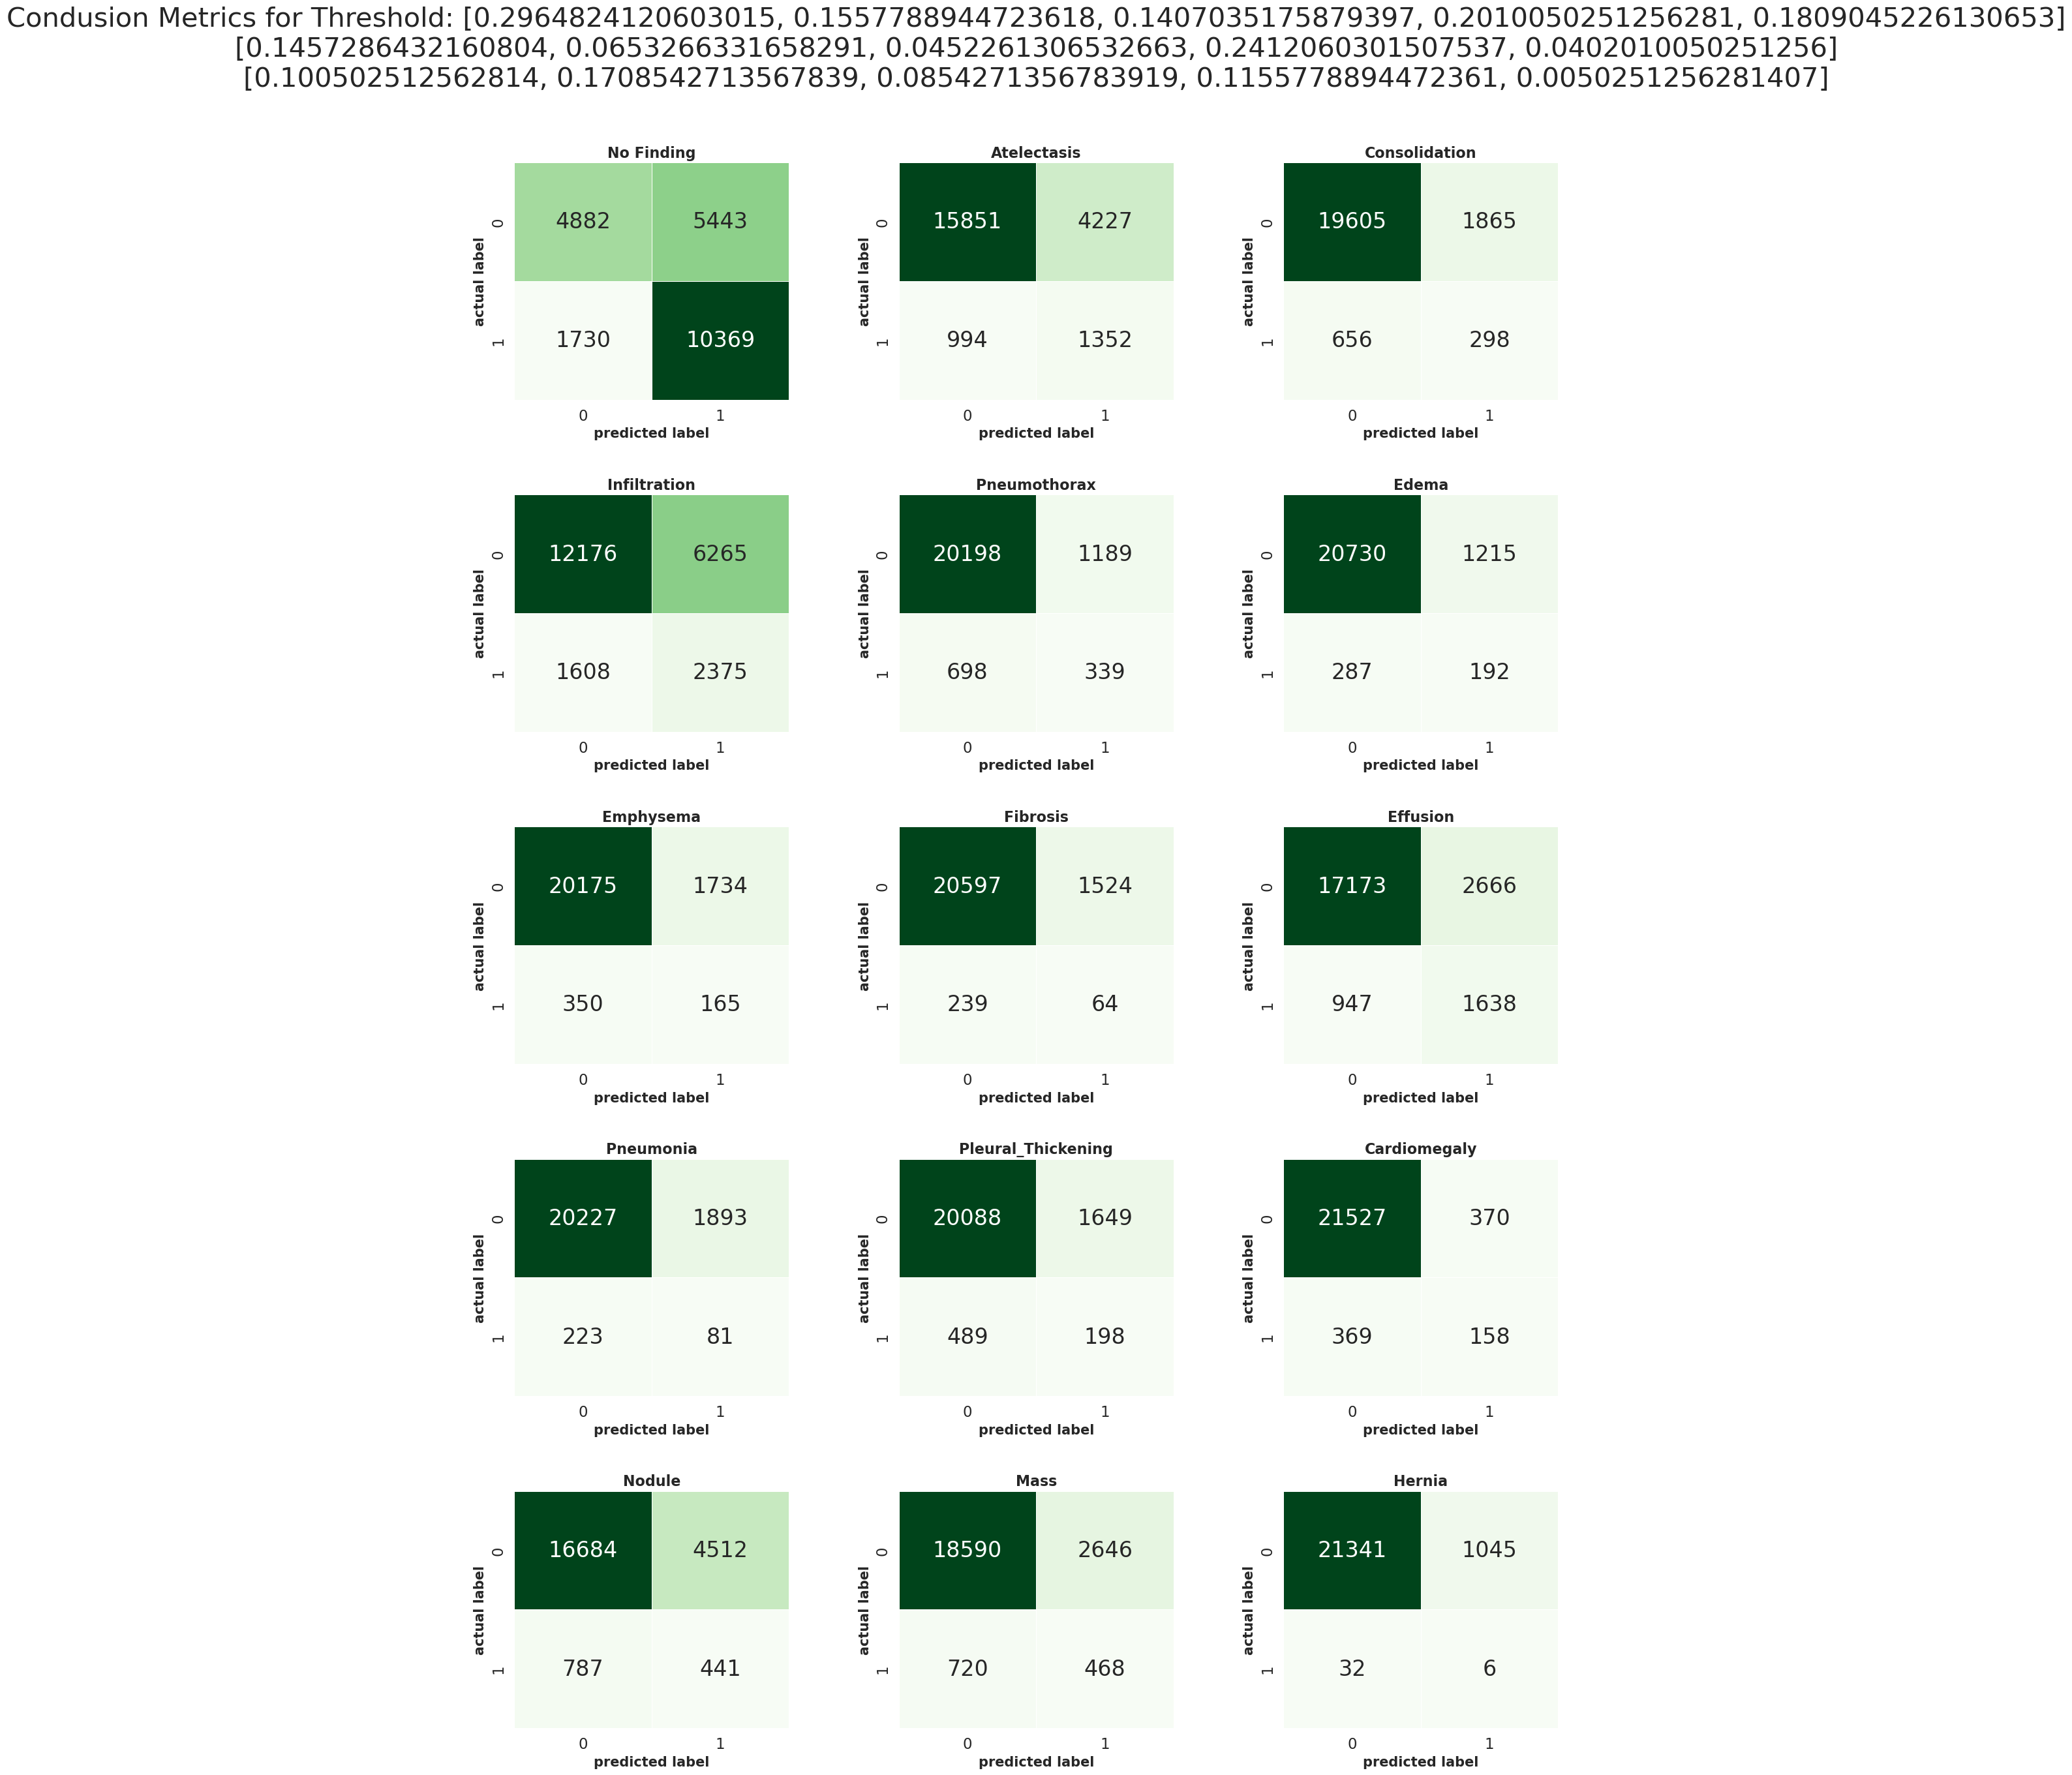

In [22]:
result = run_confusion_metrics()

Describe `tmp`
``` python
TN = tmp[0][0][0]
FP = tmp[0][0][1]
FN = tmp[0][1][0]
TP = tmp[0][1][1]
```